In [1]:
import torch
from torch.distributions import StudentT,Normal,Laplace,Gamma, Bernoulli, Categorical
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
from random import sample,seed
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from IPython.display import clear_output, display

In [2]:
from causal_cocycle.model import cocycle_model,flow_model
from causal_cocycle.optimise import *
from causal_cocycle.loss_functions import Loss
from causal_cocycle.conditioners import Constant_Conditioner, Lin_Conditioner,NN_RELU_Conditioner
from causal_cocycle.transformers import Transformer,Shift_layer,Scale_layer,RQS_layer
from causal_cocycle.helper_functions import likelihood_loss,mmd
from causal_cocycle.kernels import *
from causal_cocycle.regression_functionals import *
from causal_cocycle.distribution_estimation import *

In [3]:
Categorical(torch.tensor([1/3,1/3,1/3])).sample((10,))

tensor([2, 1, 2, 0, 1, 0, 1, 1, 1, 2])

In [30]:
# Helper functions
class MixtureDist:

    def __init__(self,sd):
        self.sd = torch.tensor(sd,requires_grad = True)

    def sample(self, shape):
        B = Bernoulli(0.5).sample(shape)
        N = self.sd*Normal(0,1).sample(shape).abs()
        C = self.sd*StudentT(1,0,1).sample(shape).abs()
        return +B*N - (1-B)*C

class MixtureDist3:

    def __init__(self,sd):
        self.sd = torch.tensor(sd,requires_grad = True)

    def sample(self, shape):
        B = Categorical(probs = torch.tensor([1/3,1/3,1/3])).sample(shape)
        N = self.sd*Normal(0,1).sample(shape).abs()
        C = self.sd*Normal(0,1).sample(shape).abs()  
        return (B==0)*(N+1) + (B==1)*(-(C+1)) + (B==2)*0
            
class MixtureDist4:

    def __init__(self,sd):
        self.sd = torch.tensor(sd,requires_grad = True)

    def sample(self, shape):
        B = Categorical(probs = torch.tensor([1/4,1/4,1/4,1/4])).sample(shape)
        N = self.sd*Normal(0,1).sample(shape).abs()
        C = self.sd*StudentT(1,0,1).sample(shape).abs()  
        return (B==0)*(N+1) + (B==1)*(-(C+1)) + (B==2)*-0.5 + (B==3)*0.5

class likelihood_loss:
    
    def __init__(self,dist):
        self.dist = dist
        if hasattr(dist,'df'):
            self.parameters = self.dist.df.requires_grad_(True)
        else:
            self.parameters = torch.tensor(1.0)
        self.loss_fn = "MLE"
    
    def __call__(self,model,inputs,outputs):
        U,logdet = model.inverse_transformation(inputs,outputs)
        
        return torch.mean(-self.dist.log_prob(U) - logdet) 

In [31]:
# Experimental settings
n = 500 # training samples
d = 1 # input dims
trials = 1 # experiment replications
ngrid = 100 # grid points for CATE
zlist = torch.linspace(-2,2,ngrid)[:,None]/d**0.5 # grid generation for CATE
a = torch.tensor([1.0]) # Int level
nu = 1 # DoF
sd = 1.0 # \sigma^2 on Y|X,Z
mc_samples = 10**5 # MC samples to approx expectations
hyper_ls = 2**torch.linspace(-2,2,5)

# Interventions
intervention_hard = lambda a,x : a + x*0
intervention_shift = lambda a,x : a + x
intervention_scale = lambda a,x : a*x
interventions = [intervention_shift]

In [36]:
# Training set up
train_val_split = 1
ntrain = int(n)
learn_rate = [1e-2]
scheduler = False
val_tol = 1e-3
batch_size = 128
val_loss = False
maxiter = 5000
miniter = 5000
RQS_bins = 8
df_init = 10.0

# Model names
Models = ["Empirical", "RQS SCM","L-RQS SCM", "TA-RQS SCM"]

# Models
SCM_models = []

tail_adapt = [False,False,False, True]

# Intervention_level
a = torch.tensor([1.0])

grad = False

In [37]:
# Estimated CATEs
CATEs_param_est = torch.zeros(len(Models),len(interventions),trials,ngrid)
for t in range(trials):
    
    # Seed set
    seed(t+1)
    torch.manual_seed(t+1)
    
    # Getting sample data
    U = MixtureDist3(1.0).sample((n,1)).detach()
   # U = Bernoulli(0.5).sample((n,1)).detach()
    # base distributions
    SCM_base_distributions = [
        #MixtureDist(1.0),
        #Bernoulli(0.5),
        MixtureDist3(1.0),
        Normal(0,1),
        Laplace(0,1),
        StudentT(df_init, 0,1)
    ]
        
    # Transformers and conditioners
    SCM_conditioners = [
        [Constant_Conditioner(init = torch.log(torch.exp(torch.ones(1))-1), grad = grad, full = False)],
        [Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
        [Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
        [Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
    ]
    SCM_transformers = [
        Transformer([Scale_layer()],logdet = True),
        Transformer([RQS_layer(),Shift_layer(),Scale_layer()],logdet = True),
        Transformer([RQS_layer(),Shift_layer(),Scale_layer()],logdet = True),
        Transformer([RQS_layer(),Shift_layer(),Scale_layer()],logdet = True),
    ]
    
    # Model estimation
        
    # Getting input-output pairs
    inputs_train,outputs_train = U,U
    inputs_val,outputs_val = [],[]

    # SCM training
    for m in range(len(Models)):
        loss_fn = likelihood_loss(dist = SCM_base_distributions[m])
        model = flow_model(SCM_conditioners[m],SCM_transformers[m])
        if m > 0:
            model.transformer.logdet = True
            optimise(model,
                          loss_fn,
                          inputs_train,
                          outputs_train,
                          inputs_val,
                          outputs_val, 
                          batch_size = batch_size,
                          learn_rate = learn_rate,
                          print_ = True,
                          plot = False, 
                          miniter = miniter,
                          maxiter = maxiter, 
                          val_tol = val_tol,
                          val_loss = val_loss,
                          scheduler = scheduler,
                          likelihood_param_opt = True)
        model.transformer.logdet = False
        SCM_models.append(model)

        if tail_adapt[m]:
            SCM_base_distributions[m] = StudentT(SCM_base_distributions[m].df.detach(),0,1)
    
    print(t)

Training loss last 10 avg is : tensor(0.3629)
99.8  % completion
0


In [38]:
Upred = []
for m in range(len(Models)):
    basepred = SCM_base_distributions[m].sample((mc_samples,1))
    Upred.append(SCM_models[m].transformation(basepred,basepred).detach())
Upred.append(Upred[0][:n])

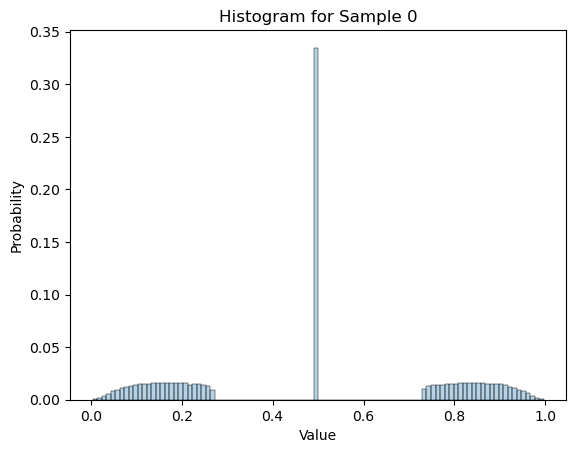

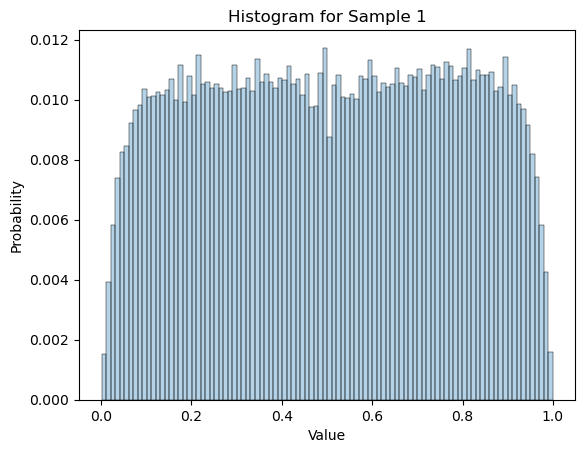

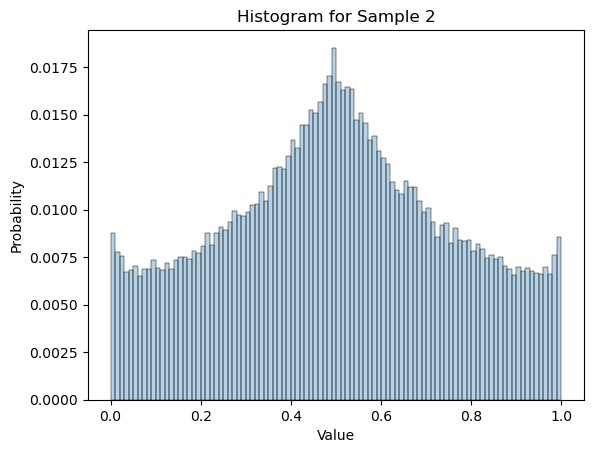

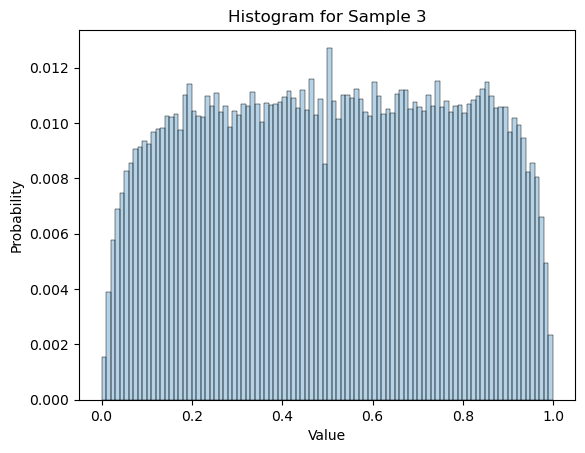

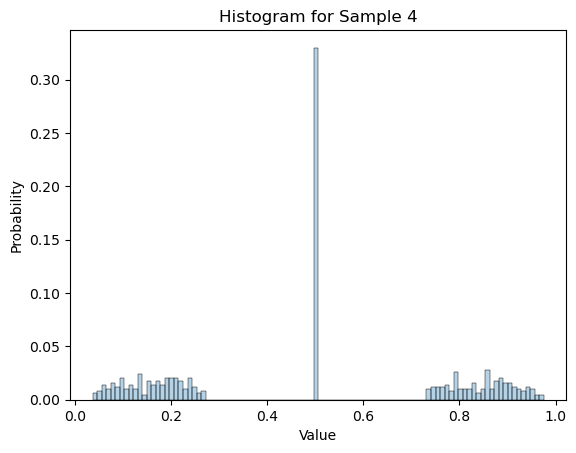

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(5):
    # Convert tensor to numpy array (detach and move to CPU if necessary)
    data = torch.sigmoid(Upred[i][:, 0]).detach().cpu().numpy()
    sns.histplot(data, bins=100, alpha=0.33, color="C0", stat = "probability")
    plt.xlabel("Value")
    plt.ylabel("Probability")
    plt.title(f"Histogram for Sample {i}")
    plt.show()

tensor(0.)
tensor(0.0473)
tensor(0.0598)
tensor(0.0482)
tensor(0.0081)


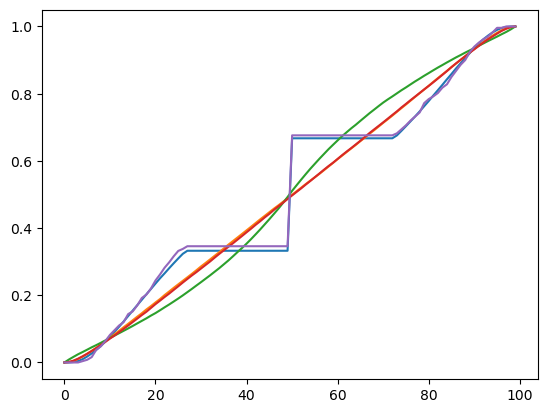

In [41]:
t = torch.linspace(0,1,100)[None]
cdfs = []
for i in range(5):
    cdfs.append((torch.sigmoid(Upred[i])<=t).float().mean(0))
    plt.plot(cdfs[i])

for i in range(5):
    print((cdfs[0]-cdfs[i]).abs().mean())

In [29]:
for i in range(5):
    print((torch.sigmoid(Upred[i][:,0])<=0.01).float().mean())
print("\n")

for i in range(5):
    print((torch.sigmoid(Upred[i][:,0])>=0.99).float().mean())
print("\n")

for i in range(5):
    print((torch.sigmoid(Upred[i][:,0])==0.5).float().mean())
print("\n")

tensor(0.0569)
tensor(0.1681)
tensor(0.2322)
tensor(0.0706)
tensor(0.0500)


tensor(0.0570)
tensor(0.4053)
tensor(0.2341)
tensor(0.0703)
tensor(0.0620)


tensor(0.3347)
tensor(0.)
tensor(3.0000e-05)
tensor(2.0000e-05)
tensor(0.3400)


